# Dataset Pipeline
https://www.tensorflow.org/guide/datasets#training_workflows
- assemble pipeline for the simle model
- could I use keras here?
- could I use tensorflow board here?

In [1]:
import os
import cifar10
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
print('tf.__version__:', tf.__version__)
print('keras.__version__:', keras.__version__)

tf.__version__: 1.9.0-rc0
keras.__version__: 2.1.6-tf


## TF.Dataset for CIFAR-10
### Features
- load data from site
- convert internal CIFAR-10 format to the useful for tf.data.dataset (TFRecord)

In [2]:
dataset_path = os.path.join(os.getcwd(), 'cifar10-data')

In [13]:
!python ./cifar10/generate_cifar10_tfrecords.py --data-dir="$dataset_path" --log-level=DEBUG

INFO:__main__:Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract to /opt/notebooks/keras-experiments/cifar10-data.
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/train.tfrecords
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/validation.tfrecords
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/eval.tfrecords
INFO:__main__:Done!


Show downloaded files

In [14]:
!ls -la "$dataset_path"

total 360492
drwxr-xr-x  7 root root       224 Sep  4 12:52 .
drwxr-xr-x 16 root root       512 Sep  4 12:51 ..
drwxr-xr-x 10 2156 1103       320 Jun  4  2009 cifar-10-batches-py
-rw-r--r--  1 root root 170498071 Aug 19 13:31 cifar-10-python.tar.gz
-rw-r--r--  1 root root  31260000 Sep  4 12:52 eval.tfrecords
-rw-r--r--  1 root root 125040000 Sep  4 12:51 train.tfrecords
-rw-r--r--  1 root root  31260000 Sep  4 12:52 validation.tfrecords


### Show dataset images of a single batch

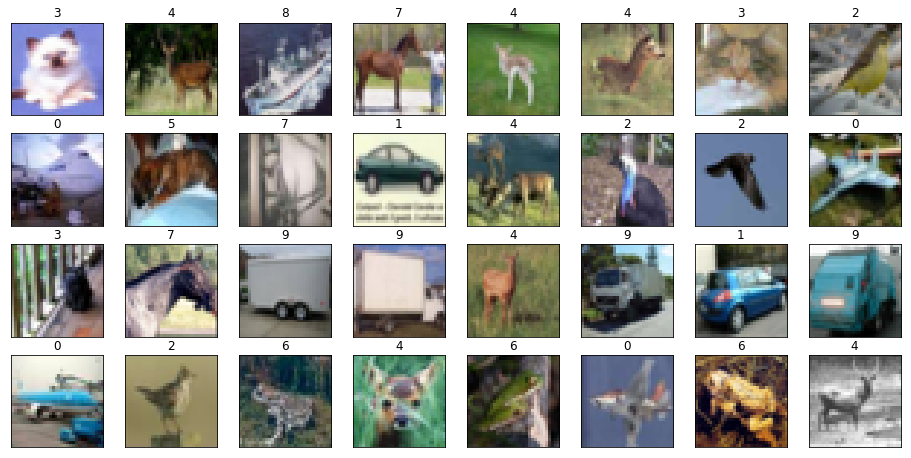

In [4]:
dataset = cifar10.dataset.TFDataSet(dataset_path).make_dataset()
iterator = cifar10.make_iterator(dataset)

with tf.Session() as sess:
    next_element = iterator.get_next()
    sess.run(tf.global_variables_initializer())
    examples = sess.run(next_element)

    grid_width = 16
    rows = 9
    items_in_a_row = 8
    plt.figure(figsize=(grid_width, grid_width / items_in_a_row * rows))
    for idx, (image, label) in enumerate(zip(examples[0]['image'], examples[1])):
        plt.subplot(rows, items_in_a_row, idx + 1)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        # for some reasons matplotlib convert color data is inverted
        plt.imshow(image/256., interpolation='nearest')
    plt.show()

### Use Pre-made estimators
#### Train model

In [105]:
def train_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='train')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    ds = ds.repeat()
    ds = ds.shuffle(1000)    
    return ds

my_feature_columns = [tf.feature_column.numeric_column('image', shape=[3, 32, 32])]

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[256, 32],
    optimizer=tf.train.AdamOptimizer(1e-4),
    dropout=0.1,
    # The model must choose between 3 classes.
    n_classes=10,
    model_dir='checkpoints/dnn-256-32')

classifier.train(input_fn=train_input_fn, steps=1000)

#### Checkpoints are here

In [103]:
print('classifier.model_dir', classifier.model_dir)
!ls "$classifier.model_dir"

checkpoint
events.out.tfevents.1534933926.b89c062a0226
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


#### Estimate model

In [104]:
def validation_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='validation')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    
# we don't need it on validation
# 
#     ds = ds.repeat()
#     ds = ds.shuffle(1000)
    return ds

accuracy_score = classifier.evaluate(input_fn=validation_input_fn)['accuracy']
print(accuracy_score)

0.0977


### TODO: Create Estimator based on TF Model

### TODO: Create Estimator based on Keras Model

- create dataset to consume TFRecord (lazy - without loading all at once to memory) - memory efficient strategy
- data augmentation (flipping images)
- TODO: cross validation
- use batch normalization, and other regularization technics
- draw 1-st layer

In [5]:
def model_fn(
    features, # This is batch_features from input_fn
    labels,   # This is batch_labels from input_fn
    mode,     # An instance of tf.estimator.ModeKeys
    params):  # Additional configuration
    
    w = params['width']
    h = params['height']
    c = 3
    
    data_format = params.get('data_format')
    if data_format is None:
        data_format = ('channels_first' if tf.test.is_built_with_cuda() else 'channels_last')
    
    if data_format == 'channels_first':
        input_shape = [c, w, h]
    else:
        assert data_format == 'channels_last'
        input_shape = [w, h, c]

    l = tf.keras.layers
    max_pool = l.MaxPooling2D((2, 2), (2, 2), padding='same', data_format=data_format)

    # The model consists of a sequential chain of layers, so tf.keras.Sequential
    # (a subclass of tf.keras.Model) makes for a compact description.
    model = tf.keras.Sequential(
      [
          l.Reshape(
              target_shape=input_shape,
              input_shape=(w * h * c,)),
          l.Conv2D(
              32,
              5,
              padding='same',
              data_format=data_format,
              activation=tf.nn.relu),
          max_pool,
          l.Conv2D(
              64,
              5,
              padding='same',
              data_format=data_format,
              activation=tf.nn.relu),
          max_pool,
          l.Flatten(),
          l.Dense(1024, activation=tf.nn.relu),
          l.Dropout(params.get('dropout', 0.4)),
          l.Dense(10)
      ])
    
    image = features['image']

    if mode == tf.estimator.ModeKeys.PREDICT:
        logits = model(image, training=False)
        predictions = {
            'classes': tf.argmax(logits, axis=1),
            'probabilities': tf.nn.softmax(logits),
        }
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=predictions,
            export_outputs={
                'classify': tf.estimator.export.PredictOutput(predictions)
            })

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=params.get('learning_rate'))

        # If we are running multi-GPU, we need to wrap the optimizer.
        if params.get('multi_gpu'):
            optimizer = tf.contrib.estimator.TowerOptimizer(optimizer)

        logits = model(image, training=True)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        accuracy = tf.metrics.accuracy(
            labels=labels, 
            predictions=tf.argmax(logits, axis=1))

        # Name tensors to be logged with LoggingTensorHook.
        tf.identity(params.get('learning_rate'), 'learning_rate')
        tf.identity(loss, 'cross_entropy')
        tf.identity(accuracy[1], name='train_accuracy')

        # Save accuracy scalar to Tensorboard output.
        tf.summary.scalar('train_accuracy', accuracy[1])

        return tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))

    if mode == tf.estimator.ModeKeys.EVAL:
        logits = model(image, training=False)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        accuracy = tf.metrics.accuracy(
            labels=labels, 
            predictions=tf.argmax(logits, axis=1))

        return tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            eval_metric_ops={
                'accuracy': accuracy,
            })
    
    raise Exception(f'Unknown mode: {mode}')

classifier = tf.estimator.Estimator(
    model_fn=model_fn,
    params={
        'learning_rate': 1e-5,
        'width': 32,
        'height': 32,
        'dropout': 0.4,
    },
    model_dir='checkpoints/simple-cnn',
)

def train_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='train')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    ds = ds.repeat()
    ds = ds.shuffle(1000)    
    return ds

def eval_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='eval')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    ds = ds.make_one_shot_iterator().get_next()
#     ds = ds.repeat()
#     ds = ds.shuffle(1000)
    return ds
    
#     return dataset.test(flags_obj.data_dir).batch(
#         flags_obj.batch_size).make_one_shot_iterator().get_next()

steps = 4 # flags_obj.train_epochs // flags_obj.epochs_between_evals

# # Train and evaluate model.
for _ in range(steps):
    print('train')
    classifier.train(
        input_fn=train_input_fn, 
        steps=1,
#         TODO: 
#         hooks=train_hooks,
    )
    print('eval')
    eval_results = classifier.evaluate(
        input_fn=eval_input_fn)
    print(f'\nEvaluation results:\n\t{eval_results}\n')



Evaluation results:
	{'accuracy': 0.2486, 'loss': 6.0865345, 'global_step': 86}


Evaluation results:
	{'accuracy': 0.2492, 'loss': 6.032852, 'global_step': 87}


Evaluation results:
	{'accuracy': 0.2511, 'loss': 5.9760566, 'global_step': 88}


Evaluation results:
	{'accuracy': 0.2519, 'loss': 5.9073143, 'global_step': 89}



## Use CIFAR-10 Dataset to train simple model
- TODO: try to use keras
- TODO: try to compare with and without TF.Dataset
- TODO: connect to tf.board